# Example: Analysis of a Straddle Position in AMD
In this example, we will analyze a straddle position in Advanced Micro Devices, Inc. (AMD) using historical options data. A long (short) straddle involves buying (selling) both a call and a put option at the same strike price and expiration date, allowing the trader to profit from significant (limited) price movements in either direction.

> __Learning Objectives:__
>
> By the end of this example, you should be able to:
> * __Construct profit diagrams for straddle positions:__ Build profit and loss profiles for long and short straddles by combining put and call contracts with the same strike price and expiration date, and compute breakeven points where the position transitions from profit to loss.
> * __Calculate probability of profit for composite positions:__ Use cumulative distribution functions of projected share price distributions to determine the likelihood that a straddle will be profitable at expiration, accounting for the two breakeven boundaries.
> * __Evaluate straddle performance using actual market data:__ Compare the current share price to breakeven points to determine whether a straddle position is profitable, and compute the profit or loss from the position.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl).

### Data
To start, load the options data using [the `MyOptionsChainDataSet(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyOptionsChainDataSet) and store the data in the `metadata::Dict{String,Any}` and `optionschain::DataFrame` variables.

In [2]:
metadata, optionschain = let
    
    # initialize -
    options_dataset = MyOptionsChainDataSet(ticker="amd");
    metadata = options_dataset.metadata;
    optionschain = options_dataset.data;

    (metadata, optionschain) # return
end;

What's in the metadata dictionary?

In [3]:
metadata |> keys

KeySet for a Dict{String, Any} with 10 entries. Keys:
  "DTE"
  "purchase_date"
  "historical_volatility"
  "underlying_share_price_ask"
  "source"
  "underlying_share_price_bid"
  "is_weekly"
  "atm_IV"
  "expiration_date"
  "underlying_share_price_mid"

In [4]:
metadata["underlying_share_price_mid"] |> x-> parse(Float64, x)

225.78

In [5]:
metadata["atm_IV"]

"0.5903"

What about the optionschain variable?

In [6]:
optionschain

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,25.0,0.8907,203.1,204.0,204.9,209.72,0,419,2.1122,0.9989,Call
2,30.0,0.8688,198.2,199.05,199.9,206.3,0,163,1.9784,0.9985,Call
3,35.0,0.847,193.2,193.98,194.75,199.75,0,17,0.0,0.0,Call
4,40.0,0.8251,188.3,189.1,189.9,176.24,0,18,1.6654,0.9985,Call
5,45.0,0.8033,183.25,184.13,185.0,174.11,0,318,1.5375,0.9985,Call
6,50.0,0.7814,178.4,179.1,179.8,167.46,0,691,1.2356,0.9996,Call
7,55.0,0.7596,173.35,174.13,174.9,177.43,0,176,1.0885,0.9998,Call
8,60.0,0.7377,168.5,169.3,170.1,162.15,0,332,1.3802,0.9967,Call
9,65.0,0.7158,163.45,164.33,165.2,175.38,0,180,1.2927,0.9967,Call


In [7]:
let
        
        # initialize -
        δ = 0.5; # set the delta for ATM search
        options_chain = optionschain;
        Sₒ = metadata["underlying_share_price_mid"] |> x-> parse(Float64, x) # mid underlying price on purchase date, 10-22-2025

        # Next, let's find contracts that are at-the-money (ATM) or near-the-money (NTM) -
        atm_call_options = filter(row -> abs((row[:Strike] - Sₒ)/Sₒ) < δ, options_chain);
end

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,115.0,0.4972,114.4,114.98,115.55,121.33,0,"3,187",0.8688,0.9853,Call
2,120.0,0.4754,109.65,110.1,110.55,109.75,1,"5,468",0.7294,0.9915,Call
3,125.0,0.4535,104.65,105.2,105.75,105.85,10,"5,090",0.8135,0.9796,Call
4,130.0,0.4317,99.9,100.35,100.8,98.6,2,"3,540",0.7909,0.9756,Call
5,135.0,0.4098,95.25,95.65,96.05,96.69,4,"3,604",0.7897,0.9681,Call
6,140.0,0.388,90.25,90.7,91.15,92.35,46,"4,005",0.7459,0.9658,Call
7,145.0,0.3661,85.45,85.93,86.4,85.15,33,"2,295",0.7261,0.9593,Call
8,150.0,0.3442,80.75,81.23,81.7,79.6,92,"6,619",0.7115,0.9508,Call
9,155.0,0.3224,76.2,76.55,76.9,77.8,3,"4,606",0.6951,0.9415,Call


### Constants
Let's set a value for the step size `Δt`, i.e., `1 day` in units of years (assuming a `365-day` year), and the risk-free rate at the time we gathered the data for the option contracts; we approximate this value using the [yield on the 10-year Treasury Note](https://ycharts.com/indicators/10_year_treasury_rate). We also set a value for the underlying share price `Sₒ` and the number of levels in the binomial tree model, `h`; we assume 6 levels per day.

In [8]:
Sₒ = metadata["underlying_share_price_mid"] |> x-> parse(Float64, x) # mid underlying price on purchase date, 10-22-2025

225.78

Other constants:

In [ ]:
Δt = (1/365); # options use 365 day year
risk_free_rate = 0.0431; # yield 10-year treasury note on 13-Jun-2024
h = 366; # 6-points per trading day
K = 230.0; # strike price (TODO: update this value based on chosen strike price)
θ = 1; # 1 = long straddle, -1 = short straddle

In this example, we'll need to do a projection of the future share price distribution at the contract's expiration date. We'll use a Geometric Brownian Motion (GBM) model to project the future share price distribution at expiration.

Let's load the single asset geometric Brownian motion (SAGBM) parameters which we estimated a few lectures ago, which include the drift and diffusion coefficients for each ticker. We'll store this data in the `parameters_df::DataFrame` variable:

In [10]:
parameters_df = let

    # load -
    df = CSV.read(joinpath(_PATH_TO_DATA,"SAGBM-Parameters-Fall-2025.csv"), DataFrame);
    df; # return
end;

We are looking at `AMD`, so let's see what the parameters for this ticker are:

In [11]:
filter(:ticker=> x-> x=="AMD", parameters_df)

Row,ticker,drift,t,lower_bound_drift,upper_bound_drift,volatility
,String7,Float64,Float64,Float64,Float64,Float64
1,AMD,0.439658,1.96,0.437351,0.441964,0.474197


### Contract models
Next, we construct contract models for the options in this example. We begin by building an instance of the [MyAmericanCallContractModel type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanCallContractModel) using the [custom build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.build-Tuple{Type{MyAmericanCallContractModel},%20NamedTuple}). The [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.build-Tuple{Type{MyAmericanCallContractModel},%20NamedTuple}) takes two arguments: the type to build, and a [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) containing the strike price `K`, the `premium` paid for the option, the days to expiration `DTE` (units: years), the `sense = 1` (long), the number of contracts in the `copy` field and the implied volatility in the `IV` field.

We save the call option contract model in the `call_option_model` variable:

In [12]:
call_option_model = let

    # initialize -
    options_dataset =  optionschain;
    premium = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Call"), options_dataset)[1,:Mid];
    IV = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Call"), options_dataset)[1,:IV]; # convert to decimal
    DTE = metadata["DTE"] |> x-> parse(Float64, x); # days to expiration (units: days)


    # build the contract model -
    call_option_model = build(MyAmericanCallContractModel, (
        K = K, 
        premium = premium, # mark price
        DTE = DTE*Δt, # units: years
        sense = θ,
        copy = 1,
        IV = IV
    ));

    call_option_model; # return the model -
end

MyAmericanCallContractModel(230.0, -1, 0.1589041095890411, 0.5912, 21.58, nothing, 1)

The put contract, which is an instance of the [MyAmericanPutContractModel type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanPutContractModel), is constructed in a similar way to the call option. We save the put option contract model in the `put_option_model` variable:

In [13]:
put_option_model = let

    # initialize -
    options_dataset =  optionschain;
    premium = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Put"), options_dataset)[1,:Mid];
    IV = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Put"), options_dataset)[1,:IV]; # convert to decimal
    DTE = metadata["DTE"] |> x-> parse(Float64, x); # days to expiration (units: days)

    # build the contract model -
    put_option_model = build(MyAmericanPutContractModel, (
        K = K, 
        premium = premium, # mark price
        DTE = DTE*Δt, # units: years
        sense = θ,
        copy = 1,
        IV = IV
    ));

    put_option_model; # return the model -
end

MyAmericanPutContractModel(230.0, -1, 0.1589041095890411, 0.5875, 21.3, nothing, 1)

___

## Task 1: Compute Profit, Loss and Breakeven Points
In this task, we compute the profit and loss (P&L) profile for the long straddle position at expiration, as well as the breakeven points.

A [straddle](https://www.investopedia.com/terms/s/straddle.asp) is a _neutral strategy_ constructed by simultaneously buying (or selling) a put and a call option on the same underlying asset `XYZ`, with the _same expiration_, and the _same strike price_. 

> __Long (short) straddle__
> 
> Let's build a long (short) straddle on AMD whose current share price is $S(0) = 225.78$ USD/share. For a long straddle, we purchase (are long) both the put and the call contracts in the straddle ($\theta = 1$). For a short straddle, we sell (are short) both the put and the call contracts in the straddle ($\theta = -1$). For a straddle, both legs have the same strike price $K$.
>
> Let's construct the profit diagram for a long (short) straddle with the parameters:
> * Leg 1: The strike price for the long (short) put leg is given by $K_{1}$ = 230 USD/share with DTE = 58 days
> * Leg 2: The strike price for the long (short) call leg is given by $K_{2}$ = 230 USD/share with DTE = 58 days

### Profit and Breakeven Analysis
Let $K_{j}$ denote the strike price of contract $j$ (USD/share), where the premium of contract $j$ is $\mathcal{P}_{j}$ (USD/share). Finally, let index $j=1$ denote the put contract, $j=2$ denote the call contract; for a straddle $K_{1}= K_{2}\equiv{K}$ (both legs have the same strike). The profit for a single straddle composite contract $\hat{P}_{\mathcal{C}}$ at expiration is given by:

$$\hat{P}_{\mathcal{C}} = \theta\cdot\left(P_{1}^{(p)}+P_{2}^{(c)}\right)$$

where $\theta_{1}=\theta_{2}\equiv\theta$ denotes a direction parameter: $\theta=-1$ if each leg is sold (short), $\theta=1$ otherwise. After substitution of the profit functions for a put and a call contract, the overall profit $\hat{P}_{\mathcal{C}}$ is given by:

$$\hat{P}_{\mathcal{C}} = \theta\cdot\Bigl[(K-S(T))^{+}+(S(T)-K)^{+}-(\mathcal{P}_{1}+\mathcal{P}_{2})\Bigr]$$

where $V_{p}(K,S(T)) = (K-S(T))^{+}=\max(K-S(T),0)$ is the payoff function for the put contract, and $V_{c}(K,S(T)) = (S(T)-K)^{+} = \max(S(T)-K,0)$ is the payoff function for the call contract. The profit (or loss) of a straddle has three regimes given by:

$$
\hat{P}_{\mathcal{C}} = \begin{cases}
  \theta\cdot\Bigl[(S(T)-K)-\left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)\Bigr]  & S(T)>K \\
  -\theta\cdot\Bigl[\mathcal{P}_{1}+\mathcal{P}_{2}\Bigr] & S(T)=K \\
    \theta\cdot\Bigl[(K-S(T))-\left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)\Bigr] & S(T)<K
\end{cases}
$$

Finally, a straddle has _two_ possible breakeven points denoted as $S^{+}$ and $S^{-}$:
* If $S(T)>K$: a straddle will breakeven at $S^{+} = K + \left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)$
* If $S(T)<K$: a straddle will breakeven at $S^{-} = K - \left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)$.

So what do we see?

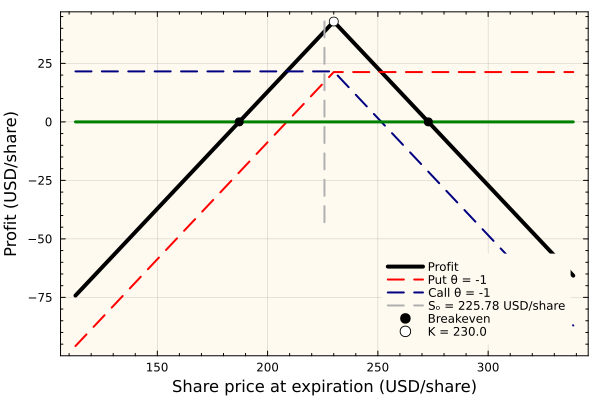

In [14]:
let
    
    # initialize -
    options_dataset =  optionschain;
    δ = 0.50; # range parameter for plotting
    premium_1 = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Put"), options_dataset)[1,:Mid];
    premium_2 = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Call"), options_dataset)[1,:Mid];
    max_loss = -1*θ*(premium_1 + premium_2);
    S = range((1-δ)*Sₒ,stop = (1+δ)*Sₒ, step=0.1) |> collect;
    number_of_steps = length(S);
    BEL = zeros(length(S))
    profit_array = profit([put_option_model, call_option_model], S);
    
    breakeven_array = zeros(2,2);
    breakeven_array[1,1] = K + (premium_1 + premium_2);
    breakeven_array[2,1] = K - (premium_1 + premium_2);
    
    plot(profit_array[:,1], profit_array[:,4], lw=4, label="Profit", c=:black, 
        bg="floralwhite", 	background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(profit_array[:,1], profit_array[:,2], lw=2, label="Put θ = $(θ)", ls=:dash, c=:red)
    plot!(profit_array[:,1], profit_array[:,3], lw=2, label="Call θ = $(θ)", ls=:dash, c=:navyblue)
    plot!(S,BEL,lw=3, c=:green, label="")
    
    VLINE = zeros(number_of_steps, 2)
    VLINE[:,1] .= Sₒ*ones(number_of_steps)
    VLINE[:,2] .= range(minimum(-1*profit_array[:,end]), stop = maximum(profit_array[:,end]), length = number_of_steps) |> collect;
    plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, label="Sₒ = $(Sₒ) USD/share")
    
    scatter!(breakeven_array[:,1], breakeven_array[:,2], c=:black, label="Breakeven", ms=5, xminorticks=true, yminorticks=true)
    scatter!([K],[max_loss], ms=5, label = "K = $(K)", msc=:black, mc=:white)
    
    xlabel!("Share price at expiration (USD/share)", fontsize=18)
    ylabel!("Profit (USD/share)", fontsize=18)
end

What are the breakeven points?

In [15]:
breakeven_array = let

    # initialize -
    options_dataset =  optionschain;
    premium_1 = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Put"), options_dataset)[1,:Mid];
    premium_2 = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Call"), options_dataset)[1,:Mid];
    
    breakeven_array = zeros(2);
    breakeven_array[1] = K + (premium_1 + premium_2);
    breakeven_array[2] = K - (premium_1 + premium_2);

    breakeven_array;
end

2-element Vector{Float64}:
 272.88
 187.12

___

## Task 2: Compute the Probability of Profit (PoP) and the Probability of Exercise (PoE)
In this task, we compute the Probability of Profit (PoP) and the Probability of Exercise (PoE) for the long straddle position at expiration.

To start, we'll need to compute the distribution of future share prices at expiration using the SAGBM model parameters we loaded earlier. We'll use a Monte Carlo simulation to generate a large number of possible future share prices at expiration, and then compute the cumulative distribution function (CDF) of the future share prices.

In [16]:
model = let

    # Initialize -
    ATM_IV = metadata["atm_IV"] |> x-> parse(Float64, x); # atm IV on purchase date, 10-22-2025

    # Case: drift = risk-free rate, volatility = max (atm_IV, historic volatility)
    model = build(MyGeometricBrownianMotionEquityModel, (
        μ = risk_free_rate, # let's mess with this ...
        σ = max(ATM_IV, filter(:ticker=> x-> x=="AMD", parameters_df)[!,:volatility] |> first)
    ));

    model;
end

MyGeometricBrownianMotionEquityModel(0.0431, 0.5903)

Now that we have a populated [MyGeometricBrownianMotionEquityModel instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) holding the `AMD` data, let's generate `number_of_samples` possible future share price values using the [sample(...) function exported by the VLQuantitativeFinancePackage.jl package](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}).
* The [sample method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}) takes a `model::MyGeometricBrownianMotionEquityModel` instance as the first argument, along with the time values that we wish to sample: `T₁::Float64` is the start time, `T₂::Float64` is the stop time (in units of `years`), `Δt::Float64` is the time step (in units of `years`), and `Sₒ::Float64` denotes the initial share price (in units of `USD/share`). Finally, we pass in the number of samples we want to generate in the `number_of_paths` argument.
* The [sample method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}) generates `number_of_paths` sample paths from $T_{1}\rightarrow{T}_{2}$ in steps of $\Delta{t}$. However, we only want the share prices corresponding to the duration of the contract, i.e., $T_{2} = \text{DTE}$. Thus, we pass the full `samples` array [using the Julia pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) to a slicing operation where we select columns `2:end` of the last row (col 1 holds the time). We store the `number_of_paths` samples of the share price at $T_{2}$ in the `endpoint::Array{Float64,1}` variable.

So what do we get?

In [17]:
endpoint_samples = let

    # initialize
    number_of_samples = 50000; # how many samples do we want to generate?
    DTE = metadata["DTE"] |> x-> parse(Float64, x); # days to expiration (units: days)

    # compute the endpoint samples -
    endpoint = VLQuantitativeFinancePackage.sample(model, (
        T₁ = 0.0,
        T₂ = (DTE)*(Δt),
        Δt = Δt,
        Sₒ = Sₒ
    ), number_of_paths = number_of_samples) |> samples -> samples[end,2:end]; # get last row from col 2 -> number_of_paths


    println("The mean projected price for GBM: $(mean(endpoint))");

    endpoint; # return
end;

The mean projected price for GBM: 227.4042706231764


#### Check: Are future GBM share prices log-normally distributed?
We expect geometric Brownian motion to generate __log-normally distributed__ share prices. However, we can check this expectation by performing an [exact one-sample Kolmogorov-Smirnov test](https://juliastats.org/HypothesisTests.jl/stable/nonparametric/#Kolmogorov-Smirnov-test) on the samples and a [LogNormal distribution estimated using maximum-likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation). 
> __Hypothesis:__ The `H0:null hypothesis` for the test is the data (endpoint samples generated using geometric Brownian motion) comes from the LogNormal distribution `d`. The alternative hypothesis `H1:alternative` is the samples are not drawn from the distribution `d`.

Let's start this check by fitting a [LogNormal distribution exported by the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.LogNormal) using the [fit_mle(...) function exported by Distributions.jl](https://juliastats.org/Distributions.jl/stable/fit/#Distributions.fit_mle-Tuple{Any,%20Any}), and save this in the `d_gbm` variable:

In [18]:
d_gbm = fit_mle(LogNormal, endpoint_samples);

Next, execute [the exact one-sample Kolmogorov–Smirnov test](https://juliastats.org/HypothesisTests.jl/stable/nonparametric/#HypothesisTests.ExactOneSampleKSTest) and check the [pvalue](https://en.wikipedia.org/wiki/P-value) using the [Julia @assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert). We reject the `H0:null hypothesis`, i.e., the `endpoint` samples are not drawn from `d_gbm`, if the `pvalue` generated by the test is _less than_ some confidence cutoff, e.g., `99%` or `0.01`.

In [19]:
test_result = ExactOneSampleKSTest(endpoint_samples, d_gbm)

Exact one sample Kolmogorov-Smirnov test
----------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.00300434

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.7575

Details:
    number of observations:   50000


`Unhide` the code block below to see how we plotted the future share price of `AMD` generated using a risk-neutral single asset geometric Brownian motion model parameterized using historical volatility.
> __What do we see?__ The geometric Brownian motion generates future share prices that are [log-normally distributed](https://en.wikipedia.org/wiki/Log-normal_distribution) (blue line) (confirmed by the check above). The [maximum-likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) of the distribution produces a model that describes the simulated endpoint share prices (red line).

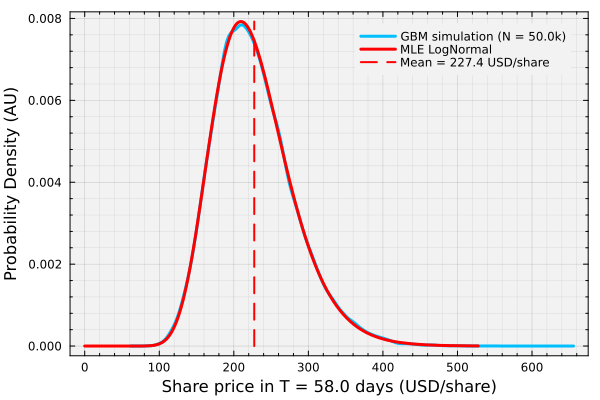

In [20]:
let

    # setup the mean line (for plotting) -
    DTE = metadata["DTE"] |> x-> parse(Float64, x); # days to expiration (units: days)
    LX = ones(100) .* mean(d_gbm);
    LY = range(0, stop = maximum(pdf.(d_gbm, range(quantile(d_gbm,0.01), stop=quantile(d_gbm,0.99), length=100))), length = 100) |> collect;

    # plot -
    density(endpoint_samples, lw=3, c=:deepskyblue1, label="GBM simulation (N = $(length(endpoint_samples)/1000)k)")
    plot!(d_gbm, lw=3, label="MLE LogNormal", c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, xminorticks=true, xminorgrid = true, yminorgrid = true)
    
    plot!(LX, LY, lw=2, ls=:dash, c=:red, label="Mean = $(round(mean(d_gbm),digits=2)) USD/share")
    xlabel!("Share price in T = $(DTE) days (USD/share)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
end

### Alternative: Future share price projection using implied volatility
Alternatively, we could use the __implied volatility__ to estimate the expected share price move over some time $0\rightarrow{T}$.
Suppose we construct a [Normal distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal) $\mathcal{N}(\mu_{IV},\sigma_{IV})$ where the mean $\mu_{IV} = S_{0}\exp(\bar{r}\cdot{T\Delta{t}})$, i.e., the risk-neutral future value of the current share price, or just $\mu_{IV}\approx{S}_{0}$ for short duration contracts, and the standard deviation $\sigma_{IV}$ is:
$$
\sigma_{IV} = S_{0}\cdot\left(\frac{\text{IV}}{100}\right)\cdot\sqrt{\text{T}\cdot\Delta{t}}
$$
using the [Normal type exported by the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal). This is only an approximate model of the future share price; it has a couple of issues: 
> __Watch out!__ This model assumes a [Normal distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal), which is problematic because it can emit negative share prices. One way to fix this issue is to use a [Truncated Normal distribution](https://juliastats.org/Distributions.jl/stable/truncate/#Truncated-Distributions) instead.

However, despite the potential issues, this model is __widely__ used to generate quick estimates of future share price ranges using the forward-looking implied volatility. Let's save the Normal IV distribution $\mathcal{N}(\mu_{IV},\sigma_{IV})$ in the `d_IV` variable:

In [21]:
d_IV = let

    # initialize -
    DTE = metadata["DTE"] |> x-> parse(Float64, x); # days to expiration (units: days)
    ATM_IV = metadata["atm_IV"] |> x-> parse(Float64, x); # atm IV on purchase date, 10-22-2025
    
    # build the Normal model -
    d = Normal(Sₒ*exp(risk_free_rate*DTE*Δt), Sₒ*(ATM_IV)*sqrt(DTE*Δt));
    d; # return

end

Normal{Float64}(μ=227.33162192473233, σ=53.12828738827033)

`Unhide` the code block below to see how we plotted the `d_gbm` and `d_IV` future share price densities at `T = 58 days`.  

> __What do we see?__ The log-normal GBM share price distribution (blue line) is right-skewed and cannot admit negative share prices. However, the Normal IV distribution (red line) is symmetric around the initial share price $S_{0}$ = `225.78 USD/share` and can admit negative share prices, albeit with a small probability.

How do the two distributions compare?

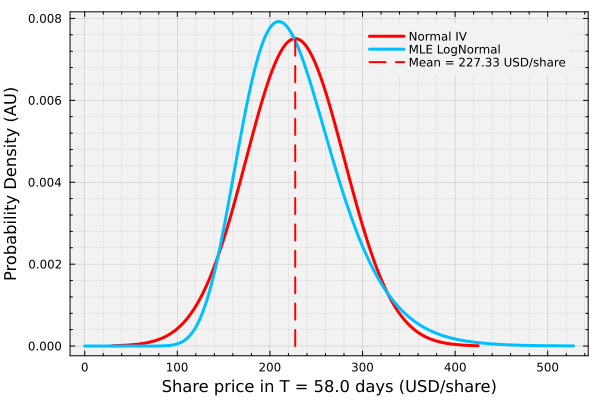

In [22]:
let

    # initialize -
    DTE = metadata["DTE"] |> x-> parse(Float64, x); # days to expiration (units: days)
    LX = ones(100) .* mean(d_IV);
    LY = range(0, stop = maximum(pdf.(d_IV, range(quantile(d_IV,0.01), stop=quantile(d_IV,0.99), length=100))), length = 100) |> collect;

    plot(d_IV, lw=3, label="Normal IV", c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, xminorticks=true, minorgrid = true);
    plot!(d_gbm, lw=3, label="MLE LogNormal", c=:deepskyblue1)
    plot!(LX, LY, lw=2, ls=:dash, c=:red, label="Mean = $(round(mean(d_IV),digits=2)) USD/share")
    
    xlabel!("Share price in T = $(DTE) days (USD/share)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
end

### Probability of Profit (POP)
The POP for a long (short) straddle position is given by the probability that the future share price at expiration $S(T)$ is outside (inside) the breakeven points $S^{+}$ and $S^{-}$. Let's look at the two cases:

> __Probability of Profit (POP) for Long Straddle__ 
> 
> The POP for a long straddle position is the probability that the future share price at expiration $S(T)$ is either greater than the upper breakeven point $S^{+}$ or less than the lower breakeven point $S^{-}$:
> $$
\begin{align*}
\text{POP} &= \mathbb{P}(S(T) > S^{+}) + \mathbb{P}(S(T) < S^{-}) \\
& = 1 - \mathbb{P}(S^{-} \leq S(T) \leq S^{+}) \\
& = 1 - \left[F_{S}(S^{+}) - F_{S}(S^{-})\right]
\end{align*}
$$
> where $F_{S}(x)$ is the cumulative distribution function (CDF) of the future share price at expiration, i.e., $F_{S}(x) = \mathbb{P}(S(T) \leq x)$.

However, if we were trading a short straddle position, the POP would be given by:
> __Probability of Profit (POP) for Short Straddle__ 
> 
> The POP for a short straddle position is the probability that the future share price at expiration $S(T)$ is between the lower breakeven point $S^{-}$ and the upper breakeven point $S^{+}$:
> $$
\begin{align*}
\text{POP} &= \mathbb{P}(S^{-} \leq S(T) \leq S^{+}) \\
& = F_{S}(S^{+}) - F_{S}(S^{-})
\end{align*}
$$
> where $F_{S}(x)$ is the cumulative distribution function (CDF) of the future share price at expiration, i.e., $F_{S}(x) = \mathbb{P}(S(T) \leq x)$.

In [23]:
pop_straddle = let

    # initialize -
    future_price_distribution = d_IV # which model are we using?
    S₊ = breakeven_array[1]; # upper breakeven price
    S₋ = breakeven_array[2]; # lower breakeven price
    POP = 0.0; # initialize

    if θ == 1
        POP = 1 - (cdf(future_price_distribution, S₊) - cdf(future_price_distribution, S₋));
    else
        POP = cdf(future_price_distribution, S₊) - cdf(future_price_distribution, S₋);
    end

    POP; # return
end

0.5798066966581348

## Task 3: Did we make money on the long straddle?
In this task, we determine whether the long straddle position was profitable based on the actual share price in the market right now. 

> __Earnings Release:__ AMD released their earnings on `2025-11-03` after market close. Analysts were anticipating EPS of 1.17 USD on revenue of 8.74 billion USD, according to Bloomberg consensus estimates. So what happened? [AMD delivers strong Q3 2025 results, beats expectations](https://www.amd.com/en/press-releases/2025-11-03-amd-delivers-strong-q3-2025-results-beats-expectations). However, did we see enough movement in the share price to make a profit on our long straddle position?

Let's check the current share price of AMD:

In [24]:
current_amd_share_price = 252.01; # USD/share on 2025-11-05, at 12:15 pm EST

Is the long straddle position profitable?

In [25]:
is_profitable_flag = let

    # initialize -
    is_profitable_flag = nothing;
    case_flag = nothing;

    if (θ == 1)
        is_profitable_flag = (current_amd_share_price > breakeven_array[1] || current_amd_share_price < breakeven_array[2]) ? true : false; # long straddle case
        case_flag = "long"
    else
        is_profitable_flag = (breakeven_array[2] ≤ current_amd_share_price ≤ breakeven_array[1]) ? true : false; # short straddle case
        case_flag = "short"
    end

    # check profitability -
    if (is_profitable_flag)
        println("The $(case_flag) straddle with K = $(K) USD/share is PROFITABLE at the current share price: $(current_amd_share_price) USD/share.")
    else
        println("The $(case_flag) straddle with K = $(K) USD/share is NOT profitable at the current share price: $(current_amd_share_price) USD/share. Breakeven prices are $(breakeven_array[2]) USD/share and $(breakeven_array[1]) USD/share.")
    end

    is_profitable_flag; # return
end;

The short straddle with K = 230.0 USD/share is PROFITABLE at the current share price: 252.01 USD/share.


What is our profit or loss?

In [26]:
let

    # initialize -
    options_dataset =  optionschain;
    case_flag = nothing;
    premium_1 = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Put"), options_dataset)[1,:Mid];
    premium_2 = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Call"), options_dataset)[1,:Mid];
    n = 1;

    if (θ == 1)
        case_flag = "long"
    else
        case_flag = "short"
    end

    # terms -
    term_1 = max(0, K - current_amd_share_price); # put option payoff
    term_2 = max(0, current_amd_share_price - K); # call option payoff
    
    # compute P/L -
    profit = θ * n * ((term_1 - premium_1) + (term_2 - premium_2));
    println("Profit or Loss from the $(case_flag) straddle: $(profit) USD/share.");
end

Profit or Loss from the short straddle: 20.870000000000008 USD/share.


## Summary
This example demonstrates how to construct and analyze a long straddle position using options data and projected share price distributions.

> __Key Takeaways:__
>
> * __Straddles have two breakeven points:__ A long straddle breaks even when the share price equals the strike price plus the total premium, or when it equals the strike price minus the total premium. The share price must move beyond either boundary for profit. A short straddle profits when the share price remains between these boundaries.
> * __Probability of profit depends on the direction parameter:__ For a long straddle, the probability of profit is calculated as the probability that the share price falls outside the breakeven boundaries at expiration. For a short straddle, it is the probability that the share price stays within the boundaries.
> * __Actual profitability depends on share price movement:__ The straddle position is evaluated by comparing the current share price to the breakeven points and calculating the combined payoffs from both the put and call contracts minus the total premium paid.

Understanding straddle positions enables traders to profit from significant price movements without predicting direction.
___

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses should be used.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.